# Speaker Classification
---
Classify the speaker based on voice
___

## Import Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## Configuration

In [3]:
np.random.seed(42)
DATA = Path("../data/Words_RPS_For_DR1/")

## Load Data

**NOTES: Batch size for smaller datasets should be small**

In [4]:
data = ImageDataBunch.from_folder(DATA, train=".", valid_pct=0.2, size=300, bs=10)

In [5]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (2300 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
FCJF0,FCJF0,FCJF0,FCJF0,FCJF0
Path: ../data/Words_RPS_For_DR1;

Valid: LabelList (574 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
FSJK1,MPSW0,MEDR0,MMGG0,FVFB0
Path: ../data/Words_RPS_For_DR1;

Test: None

## Exploratory Data Analysis

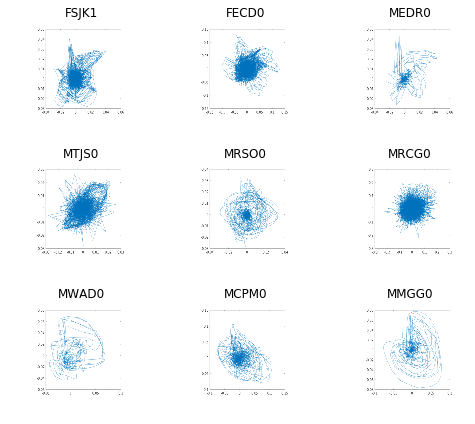

In [6]:
data.show_batch(rows=3, figsize=(7,6))

In [9]:
data.classes

['FCJF0',
 'FDAW0',
 'FDML0',
 'FECD0',
 'FETB0',
 'FJSP0',
 'FKFB0',
 'FMEM0',
 'FSAH0',
 'FSJK1',
 'FSMA0',
 'FTBR0',
 'FVFB0',
 'FVMH0',
 'MCPM0',
 'MDAC0',
 'MDPK0',
 'MEDR0',
 'MGRL0',
 'MJEB1',
 'MJWT0',
 'MKLS0',
 'MKLW0',
 'MMGG0',
 'MMRP0',
 'MPGH0',
 'MPGR0',
 'MPSW0',
 'MRAI0',
 'MRCG0',
 'MRDD0',
 'MRSO0',
 'MRWS0',
 'MTJS0',
 'MTPF0',
 'MTRR0',
 'MWAD0',
 'MWAR0']

In [10]:
data.c

38

In [11]:
len(data.train_ds)

2300

In [12]:
len(data.valid_ds)

574

In [13]:
data.batch_size

10

## Train Model: Resnet34 already trained on Imagenet 

In [15]:
learner = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

In [16]:
learner.fit_one_cycle(4)

KeyboardInterrupt: 

**NOTES:** The model seems to have overfit because train_loss has gone below validation_loss. Need to train for three epochs only.  
**NOTES:** Lowering the batch size and training epochs gets to a good optimized accuracy. Need to improve it further

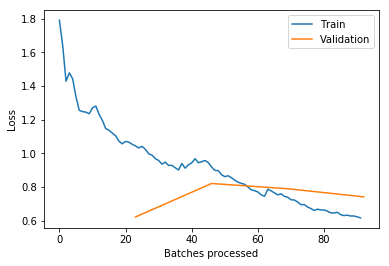

In [17]:
learner.recorder.plot_losses()

## Save Model

In [18]:
learner.save('stage-1')

## Results

In [19]:
doc(ClassificationInterpretation)

class ClassificationInterpretation [source] ClassificationInterpretation ( `data` : DataBunch , `probs` : Tensor , `y_true` : Tensor , `losses` : Tensor ) 
 
 Interpretation methods for classification models. 
 Show in docs

In [20]:
interp = ClassificationInterpretation.from_learner(learner)

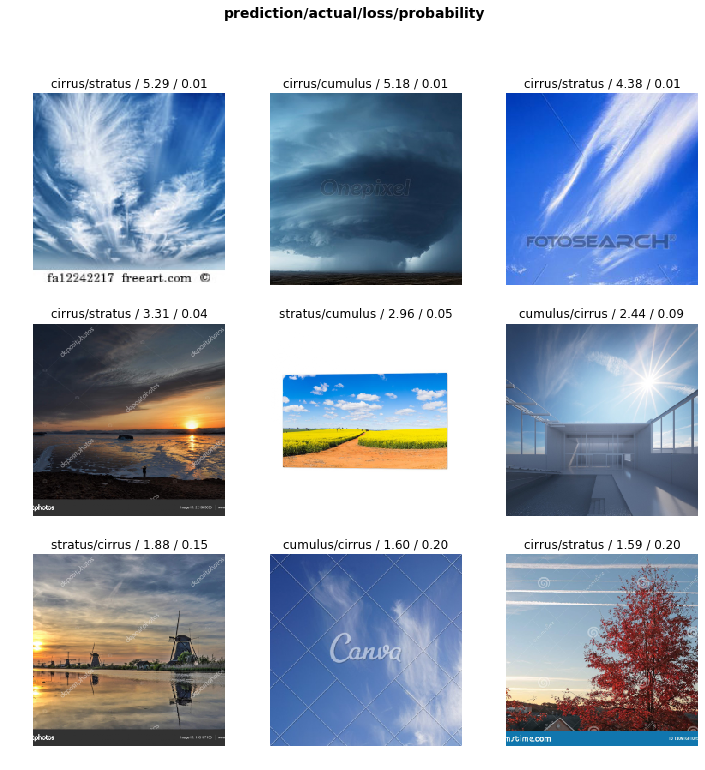

In [21]:
interp.plot_top_losses(9)

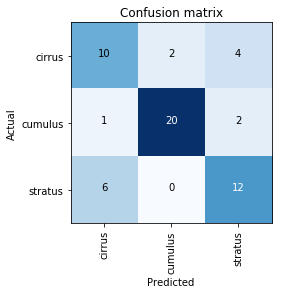

In [22]:
interp.plot_confusion_matrix()

**NOTES:** Stratus and cirrus are mostly confused with each other. Model seems to be doing well with cumulus as expected.

## Finetune Model

**Train a model from scratch to see the error introduced by transfer learning if any**

In [23]:
learner.unfreeze()

In [24]:
learner.fit_one_cycle(2)

**NOTES:** When the entire network is trained for only two epochs it results in overfitting

**Finetune model with differential learning rate**

In [30]:
learner.load('stage-1');

In [31]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


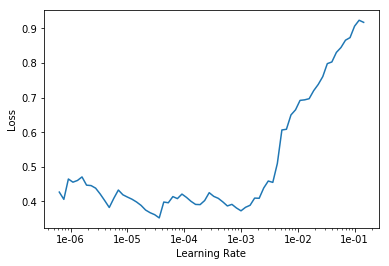

In [32]:
learner.recorder.plot()

**NOTES:** 1e-05 seems like the best learning rate

In [28]:
learner.unfreeze()

In [33]:
learner.fit_one_cycle(3, max_lr=slice(1e-6, 1e-5))

**NOTES:** No improvements. Apparently the model always seem to do better in the first epoch for some reason. Is this overfitting?

**Experimenting with just one epoch**

In [34]:
learner.load('stage-1');

In [35]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


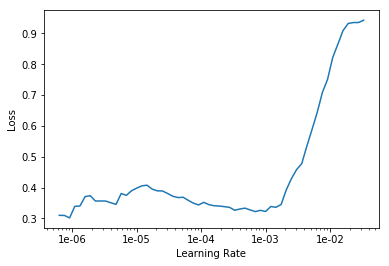

In [36]:
learner.recorder.plot()

**NOTES:** 2 * 1e-05 seems like the best learning rate

In [37]:
learner.unfreeze()

In [39]:
learner.fit_one_cycle(3, max_lr=slice(1e-6, 2*1e-5))

**NOTES:** The exact same accuracy as before. Something about the cyclical learning procedure it seems.

## Save Model

In [40]:
learner.save('stage-2')

## Results

In [41]:
interp = ClassificationInterpretation.from_learner(learner)

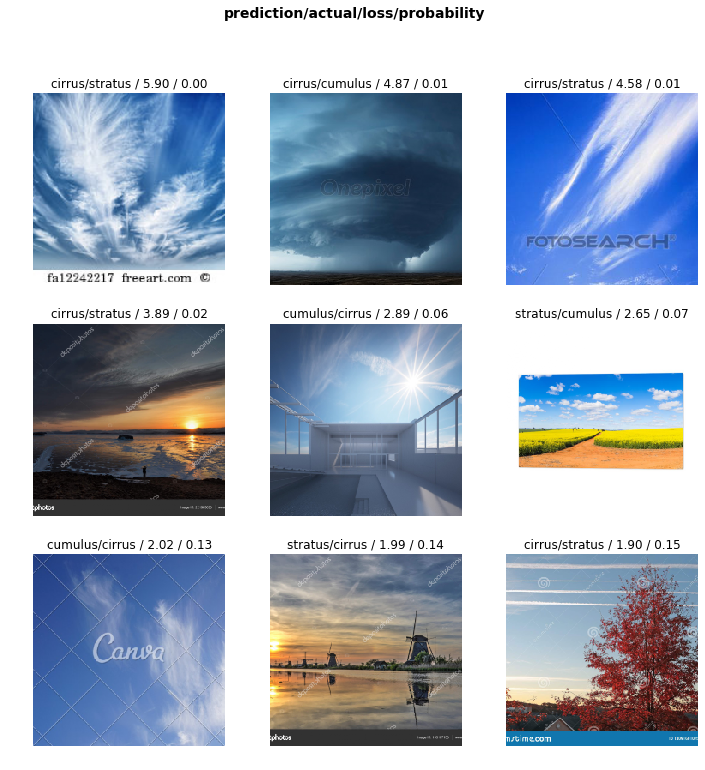

In [42]:
interp.plot_top_losses(9)

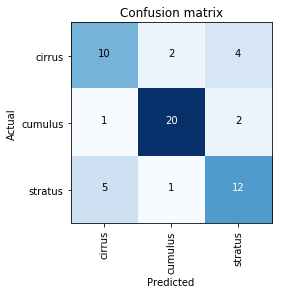

In [43]:
interp.plot_confusion_matrix()

**NOTES:** Similar problem even after fine-tuning. Stratus is routinely confused with Cirrus and vice-versa. Manually they also seem very hard to tell apart as well. So, this seems like an honest mistake. We can still try to clean the data by manually observing the instances where a Stratus cloud is seriously a Cirrus.

## Data Cleaning

In [44]:
from fastai.widgets import *

In [45]:
doc(DatasetFormatter.from_toplosses)

In [46]:
ds, idxs = DatasetFormatter.from_toplosses(learner)

In [47]:
ImageCleaner(ds, idxs, DATA)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

# Retraining

## Load Data

In [48]:
doc(ImageDataBunch.from_df)

from_df [source] from_df ( `path` : PathOrStr , `df` : DataFrame , `folder` : PathOrStr = `'.'` , `label_delim` : str = `None` , `valid_pct` : float = `0.2` , `fn_col` : IntsOrStrs = `0` , `label_col` : IntsOrStrs = `1` , `suffix` : str = `''` , `kwargs` : Any ) → ImageDataBunch 
 
 Create from a DataFrame df . 
 Show in docs

In [49]:
old_data = ImageDataBunch.from_folder(DATA, train=".", valid_pct=0.2, size=224, bs=10)

In [50]:
df = pd.read_csv(DATA/'cleaned.csv', header='infer')

In [52]:
data = ImageDataBunch.from_df(DATA, df, valid_pct=0.0, size=224, bs=10)

In [53]:
len(data.valid_ds), len(old_data.valid_ds)

(1, 57)

In [54]:
data.valid_dl = old_data.valid_dl

In [55]:
len(data.valid_ds)

57

In [56]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (229 items)
[Category cirrus, Category cirrus, Category cirrus, Category cirrus, Category cirrus]...
Path: ../data
x: ImageItemList (229 items)
[Image (3, 154, 275), Image (3, 311, 450), Image (3, 657, 960), Image (3, 683, 1024), Image (3, 1167, 1600)]...
Path: ../data;

Valid: LabelList
y: CategoryList (57 items)
[Category cirrus, Category stratus, Category stratus, Category stratus, Category stratus]...
Path: ../data
x: ImageItemList (57 items)
[Image (3, 399, 500), Image (3, 439, 657), Image (3, 1120, 1500), Image (3, 512, 334), Image (3, 371, 436)]...
Path: ../data;

Test: None

## Exploratory Data Analysis

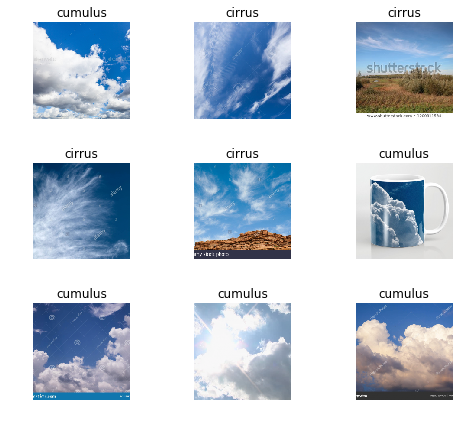

In [57]:
data.show_batch(rows=3, figsize=(7,6))

In [58]:
data.classes

['cirrus', 'cumulus', 'stratus']

In [59]:
data.c

3

In [60]:
data.sanity_check()

In [61]:
len(data.train_ds)

229

In [62]:
len(data.valid_ds)

57

In [63]:
data.batch_size

10

## Train Model: Resnet34 already trained on Imagenet 

In [64]:
doc(create_cnn)

create_cnn [source] create_cnn ( `data` : DataBunch , `arch` : Callable , `cut` : Union [ int , Callable ]= `None` , `pretrained` : bool = `True` , `lin_ftrs` : Optional [ Collection [ int ]]= `None` , `ps` : Floats = `0.5` , `custom_head` : Optional [ Module ]= `None` , `split_on` : Union [ Callable , Collection [ ModuleList ], NoneType ]= `None` , `bn_final` : bool = `False` , `kwargs` : Any ) → Learner 
 
 Build convnet style learners. 
 Show in docs

In [65]:
learner = create_cnn(data, models.resnet34, metrics=[error_rate, accuracy])

In [67]:
learner.fit_one_cycle(3)

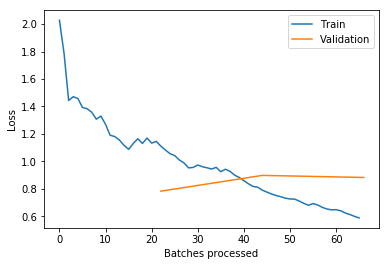

In [68]:
learner.recorder.plot_losses()

**NOTES:** No improvements in accuracy. Maybe the 78% is the best you can do in this dataset.

## Save Model

In [69]:
learner.save('stage-3')

## Results

In [70]:
doc(ClassificationInterpretation)

class ClassificationInterpretation [source] ClassificationInterpretation ( `data` : DataBunch , `probs` : Tensor , `y_true` : Tensor , `losses` : Tensor ) 
 
 Interpretation methods for classification models. 
 Show in docs

In [71]:
interp = ClassificationInterpretation.from_learner(learner)

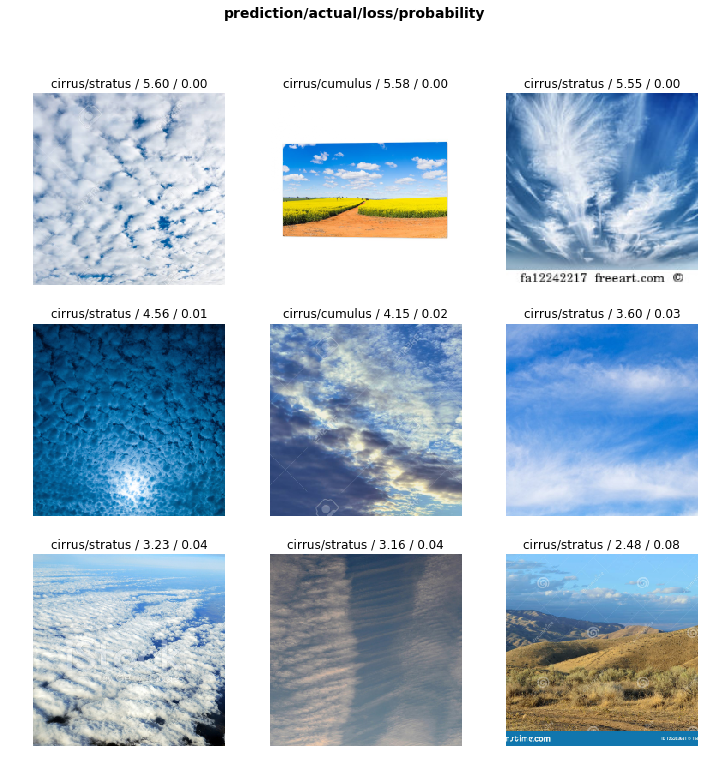

In [72]:
interp.plot_top_losses(9)

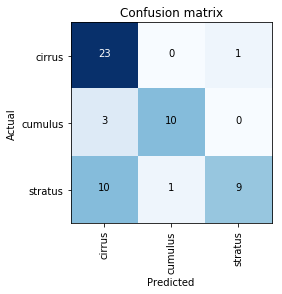

In [73]:
interp.plot_confusion_matrix()

**NOTES:** The validation set is quite noisy. All Cirrus clouds are mislabelled as Stratus clouds. Hence, the models seems to be doing fine.

## Finetune Model

**Train a model from scratch to see the error introduced by transfer learning if any**

In [82]:
learner.load('stage-3');

In [83]:
learner.unfreeze()

In [84]:
learner.fit_one_cycle(2)

In [85]:
learner.fit_one_cycle(2)

**NOTES:** Training the model in two separate cycles seems to improve it. Let's see analyse the prediction results to understand this behaviour.

In [76]:
learner.save('stage-4')

## Results

In [89]:
learner.load('stage-4');

In [92]:
interp = ClassificationInterpretation.from_learner(learner)

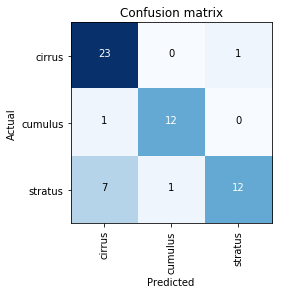

In [93]:
interp.plot_confusion_matrix()

**NOTES:** Looks slightly better than before

## Finetuning

**Finetune model with differential learning rate**

In [94]:
learner.load('stage-4');

In [95]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


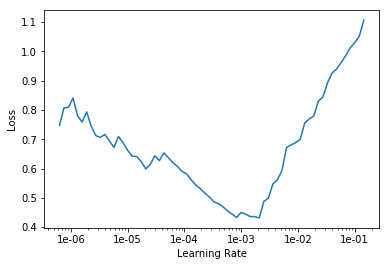

In [96]:
learner.recorder.plot()

**NOTES:** 1e-4 seems like the best learning rate

In [97]:
learner.unfreeze()

In [98]:
learner.fit_one_cycle(4, max_lr=slice(1e-6, 1e-4))

**NOTES:** Looks like it cannot be improved anymore

## Save Model

In [99]:
learner.save('stage-5')

## Results

In [111]:
learner = create_cnn(data, models.resnet34, metrics=[error_rate, accuracy])

In [112]:
learner.load('stage-5');

In [113]:
interp = ClassificationInterpretation.from_learner(learner)

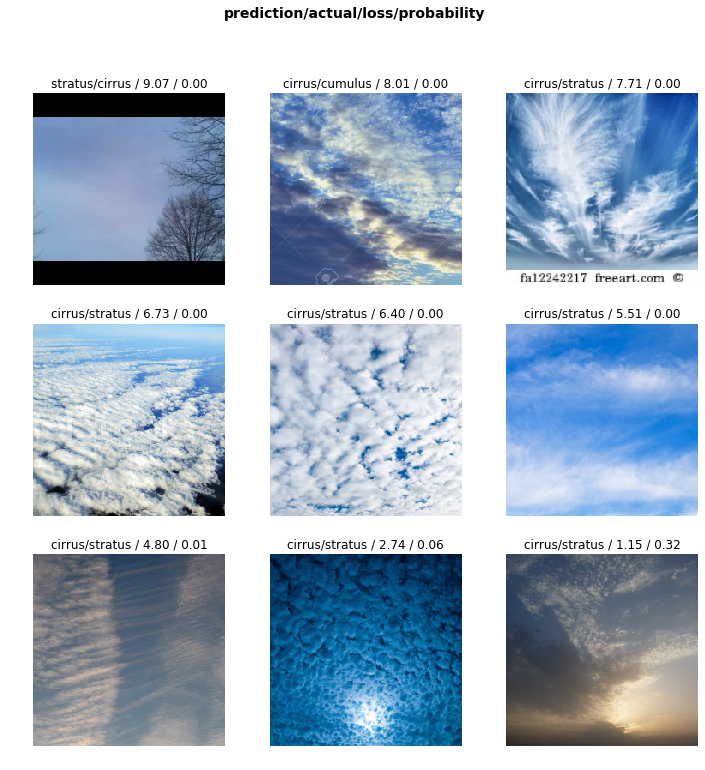

In [114]:
interp.plot_top_losses(9)

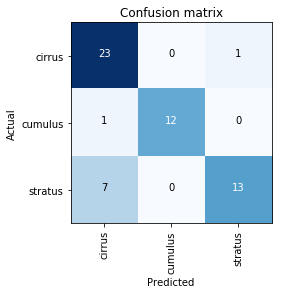

In [115]:
interp.plot_confusion_matrix()

**NOTES:**  
Everything looks great except for the confusion between Stratus & Cirrus clouds. On visual examination, we can see that these clouds are indeed difficult for a human to classify at the first glance. Can a model do better? 

## Ready for Production

In [117]:
learner.load('stage-5');

In [118]:
learner.export()

**Sanity Check**

In [119]:
del(learner)

In [120]:
defaults.device = torch.device('cpu')

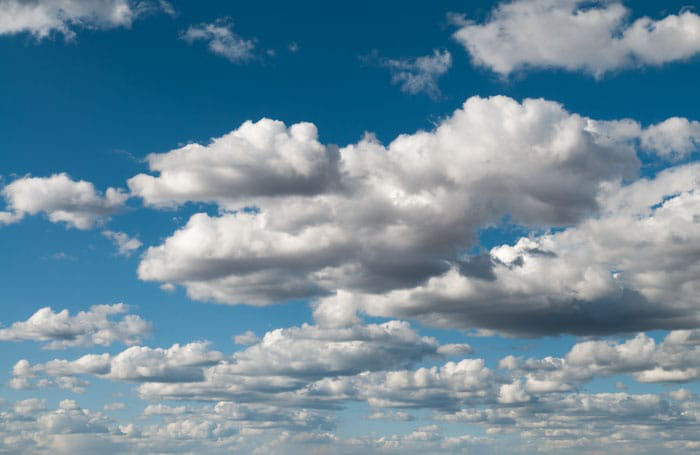

In [121]:
img = open_image(DATA/'cumulus'/'00000000.jpg')
img

In [122]:
learner = load_learner(DATA)

In [123]:
pred_class, pred_idx, pred_proba = learner.predict(img)

In [125]:
pred_class, pred_idx, pred_proba

(Category cumulus, tensor(1), tensor([1.4884e-05, 9.9980e-01, 1.8026e-04]))